## ЦЕЛЬ: 
 После настройки  фронтовой аналитики в AppMetrica необходимо  проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

## Задачи:
1.Составить график с событиями по дням и ответ на вопросы: В каком месте маркетинг работает недостаточно хорошо? За счёт чего можно расти?  
2.Составить график с распределением трафика (открытие приложения) по группам «Установили в тот же день» и «Остальные».  
3.Составить график с динамикой установок приложения по каналам привлечения и ответ на вопрос: С каких платных каналов приходит больше и меньше  всего пользователей?  
4.Провести анализ: на каком этапе воронки «отваливается» большая часть клиентов (отдельно для зарегистрированных и для незарегистрированных пользователей). Сформулируйте предложение по оптимизации.  
5.Выбрать  лучшего и худшего каналов по конверсии в первую покупку.  
6.Расчитать  ROMI для всех каналов.  
7.Составить таблицу когорт (в абс. и %) по неделе первого посещения, выбор самой большой и самой активной когорт.  
8.Составить таблицу когорт (в абс. и %) по неделе первой покупки, выбор самой активной когорты и анализ динамики активности.  
9.Расчитать  средний/медианный чек по когортам (недели первой покупки) в каждую неделю с момента первой покупки, указание диапазонов.

## 1.Составить график с событиями по дням и ответ на вопросы: В каком месте маркетинг работает недостаточно хорошо? За счёт чего можно расти?

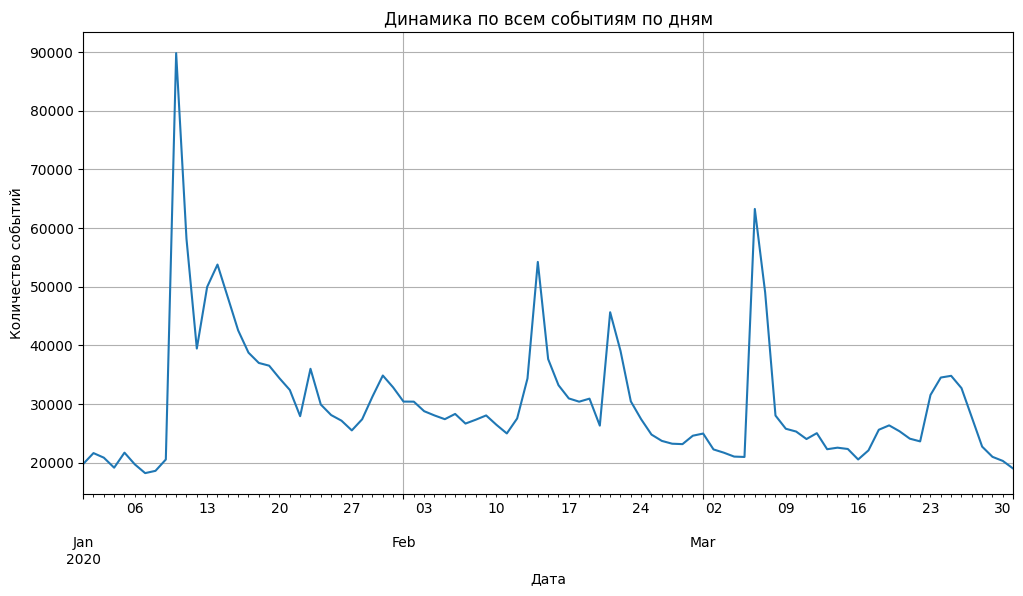

In [31]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# импортируем CSV- файл
data = pd.read_csv('C:\IDE\SF_case_data.csv')

# Преобразуем столбец 'Дата' в формат даты
data['data'] = pd.to_datetime(data['date'])

# Сгруппируем данные по дням и посчитаем количество событий
events_by_day = data.groupby('data').size()

# Построим график
plt.figure(figsize=(12, 6))
events_by_day.plot(kind='line')
plt.title('Динамика по всем событиям по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid()
plt.show()

Вывод:   
 На графике видно, что количество событий резко падает в определенные дни, это может свидетельствовать о неэффективности маркетинговых мероприятий в эти дни.

Чтобы расти за счет чего-то, можно использовать следующие стратегии:

1. Увеличение бюджета на маркетинговые кампании: инвестиции в рекламу и промо-акции могут привести к привлечению новых клиентов.

2. Улучшение целевой аудитории: анализ данных о пользователях и определение целевой аудитории более точно поможет привлечь новых пользователей.

3. Внедрение новых маркетинговых стратегий: использование инновационных методов маркетинга, таких как инфлюенсер-маркетинг или контент-маркетинг, может привести к росту числа событий.

In [2]:
max_events_day = events_by_day.idxmax()
print(f'Больше всего событий было {max_events_day.strftime("%d.%m.%Y")}')

Больше всего событий было 10.01.2020


## 2.Составить график с распределением трафика (открытие приложения) по группам «Установили в тот же день» и «Остальные».  

In [3]:
# Сначала мы находим дату, когда были установлены приложения:

installs = data[data['event'] == 'app_install']
data['install_date'] = data['device_id'].map(installs.set_index('device_id')['date'])

# После этого мы пишем функцию, которая покажет, какие пользователи «Установили в тот же день» и применяем ее к нашему датафрейму:
def new_column(date1,date2,value):
    if date1 == date2:
        return value


conditions = [
    data['date'] == data['install_date'],  # Установили в этот же день
    data['date'] != data['install_date']   # Остальные
]

# Определяю соответствующие значения для каждого условия
values = ['Установили в этот же день', 'Остальные']

# Создаю новый столбец "install_group" 
data['install_group'] = np.select(conditions, values, default='Остальные')

# Далее заполняем пропуски в колонке ‘install_group’ и заменяем их на ‘Остальные’.
data['install_group'] = data['install_group'].fillna('Остальные')

# создаем новый датафрейм, чтобы отобразить динамику по дням:
df1 = data[data['event'] == 'app_start'].groupby(['date','install_group']).size().reset_index(name = 'users')

#  создаею два датафрейма и строюграфики:
df_the_same_day = df1[df1['install_group'] =='Установили в этот же день']
df_other_day = df1[df1['install_group'] =='Остальные']

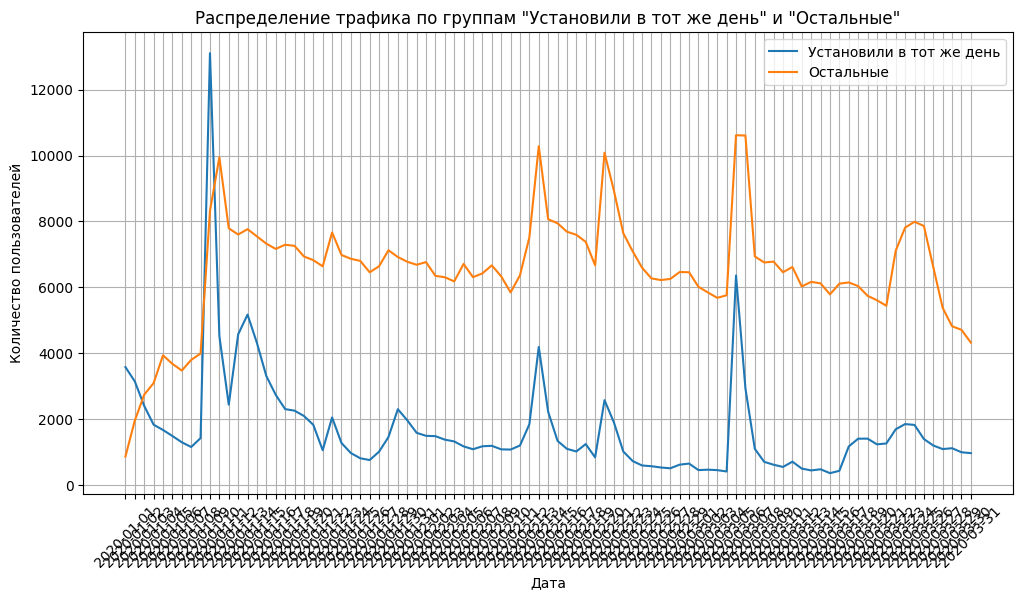

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(df_the_same_day['date'], df_the_same_day['users'], label='Установили в тот же день')
plt.plot(df_other_day['date'], df_other_day['users'], label='Остальные')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.title('Распределение трафика по группам "Установили в тот же день" и "Остальные"')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## 3.Составиь график с динамикой установок приложения по каналам привлечения и ответ на вопрос: С каких платных каналов приходит больше и меньше  всего пользователей?

In [5]:
# В какой день доля трафика от инсталлов была наибольшей?

gr1 = df1[df1['install_group'] == 'Остальные']
gr2 = df1[df1['install_group'] != 'Остальные']
stat = gr1.merge(gr2, how = 'left', on = 'date')


stat['Доля трафика с инсталлов, %'] = stat['users_y']/(stat['users_y'] +stat['users_x'])
stat['gr'] = 'Трафик с инсталлов'
stat.sort_values('Доля трафика с инсталлов, %', ascending = True).head(3)

,date,install_group_x,users_x,install_group_y,users_y,"Доля трафика с инсталлов, %",gr
75,2020-03-16,Остальные,5786,Установили в этот же день,360,0.058575,Трафик с инсталлов
76,2020-03-17,Остальные,6111,Установили в этот же день,431,0.065882,Трафик с инсталлов
64,2020-03-05,Остальные,5759,Установили в этот же день,411,0.066613,Трафик с инсталлов


In [6]:
# С какого канала в Q1 пришло больше всего пользователей?


df_app_install = data[data['event'] == 'app_install'].groupby(['date','utm_source']).size().reset_index(name = 'users')
pivot_table_data=pd.pivot_table(df_app_install, values='users', index='utm_source', aggfunc='sum').sort_values('users',ascending = False)
pivot_table_data

,users
utm_source,
-,32460
yandex-direct,29368
google_ads,26286
vk_ads,23189
instagram_ads,20096
facebook_ads,13916
referal,9282


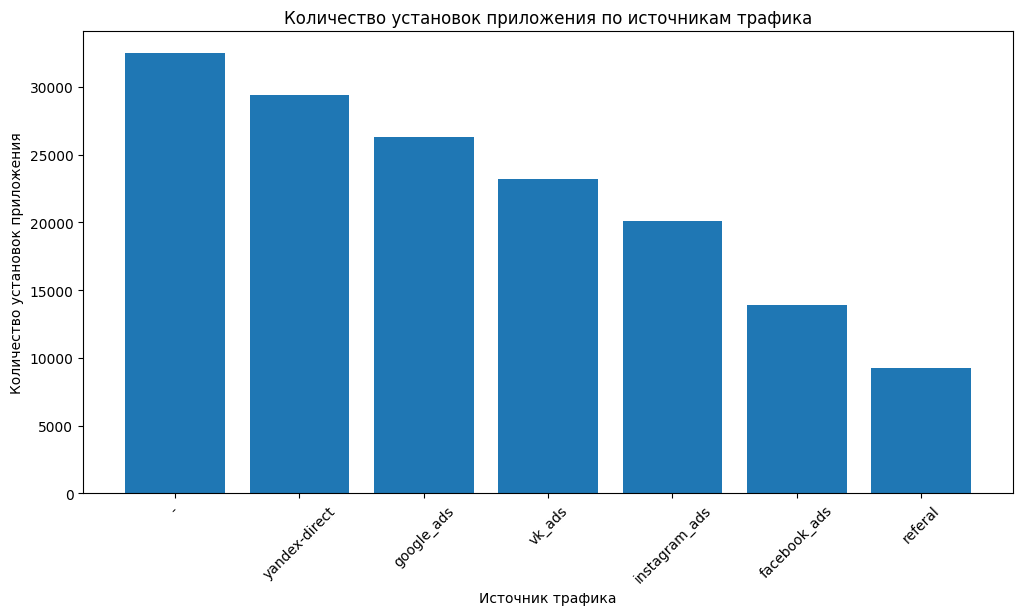

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(pivot_table_data.index, pivot_table_data['users'])
plt.xlabel('Источник трафика')
plt.ylabel('Количество установок приложения')
plt.title('Количество установок приложения по источникам трафика')
plt.xticks(rotation=45)
plt.show()

Вывод:  
Больше всего пользователей приходтит с канала Яндекс, это означает, что канал  является наиболее эффективным и приносит больше клиентов  бизнесу по сравнению с другими каналами привлечения трафика.Следует продолжать инвестировать в этот канал и оптимизировать его для достижения еще большего успеха.

Меньше всего  пользователей приходтит с канала Реферальной программы, возможно, стоит пересмотреть стратегию этого канала, чтобы увеличить количество привлеченных пользователей или перераспределить бюджет на более эффективные каналы привлечения трафика.

In [8]:
# С какого канала было больше всего первых открытий приложения? 

df2= data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['date','utm_source']).size().reset_index(name = 'users')
pd.pivot_table(df2, values='users', index='utm_source', aggfunc='sum').sort_values('users',ascending = False)

,users
utm_source,
-,41456
yandex-direct,34441
google_ads,31437
vk_ads,27905
instagram_ads,24818
facebook_ads,18844
referal,11983


## 4.Провсети анализ: на каком этапе воронки «отваливается» большая часть клиентов (отдельно для зарегистрированных и для незарегистрированных пользователей).

Для зарегистрированных пользователей

In [9]:
#Находим пользователей, которые зарегистрированы и добавляем новый столбец с 1, что означает, что они зарегистрированы.
first_registration = data[data['event'] == 'register'].sort_values('date').drop_duplicates('device_id')
first_registration['finally_registered'] = 1
# Добавляем столбец с датой регистрации в табличку data и добавляем еще один столбец 'finally_registered' с значением 1, который обозначает, что регистрация была. Для этого используем функцию map.
data['first_registration'] = data['device_id'].map(first_registration.set_index('device_id')['date'])
data['finally_registered'] = data['device_id'].map(first_registration.set_index('device_id')['finally_registered'])
# После этого мы сравниваем дату 'first_registration' с 'date', и обозначаем зарегистрированных пользователей -1, а незарегистрированных 0.
already_reg = data[data['first_registration'] < data['date']]
already_reg['registered'] = 1
requires_reg1 = data[(data['first_registration'].isna() == True)]
requires_reg1['registered'] = 0
requires_reg2 =  data[data['first_registration'] >= data['date']]
requires_reg2['registered'] = 0
# Далее мы объединяем полученные в табличку data и выбираем тех, кто дошли до покупки.
data = pd.concat([already_reg,requires_reg1,requires_reg2])
# После этого подсчитываем зарегистрированных и незарегистрированных пользователей на всех этапах.
data[data['event'] == 'tap_basket'].groupby('registered').count()
# Теперь, чтобы подготовить финальную табличку с количеством пользователей на разных этапах для расчета конверсии зарегистрированных пользователей, создаем новую табличку, выбираем только зарегистрированных и с помощью функции crosstab делаем объединение таблиц. 
reg = data[data['registered'] == 1]
funnel_reg = pd.crosstab(reg.utm_source, reg.event, values=reg.device_id, aggfunc=pd.Series.nunique)
# После этого проделываем то же самое, но с незарегистрированными пользователями.
# На последних двух шагах мы рассчитываем конверсии на каждом этапе для зарегистрированных и незарегистрированных пользователей.
reg = data[data['registered'] == 1]
funnel_reg = pd.crosstab(reg.utm_source, reg.event, values=reg.device_id, aggfunc=pd.Series.nunique)
funnel_reg['1 step'] = funnel_reg['search']*100/funnel_reg['app_start']
funnel_reg['2 step'] = funnel_reg['choose_item']*100/funnel_reg['search']
funnel_reg['3 step'] = funnel_reg['tap_basket']*100/funnel_reg['choose_item']
funnel_reg['5 step'] = funnel_reg['purchase']*100/funnel_reg['tap_basket']
funnel_reg

C:\Users\New\AppData\Local\Temp\ipykernel_7480\1906462572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  already_reg['registered'] = 1
C:\Users\New\AppData\Local\Temp\ipykernel_7480\1906462572.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  requires_reg1['registered'] = 0
C:\Users\New\AppData\Local\Temp\ipykernel_7480\1906462572.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

event,app_start,choose_item,purchase,search,tap_basket,1 step,2 step,3 step,5 step
utm_source,,,,,,,,,
-,9482,8728,5492,9355,7850,98.660620,93.297702,89.940422,69.961783
facebook_ads,5606,5154,3333,5527,4694,98.590796,93.251312,91.074893,71.005539
google_ads,5399,4948,3121,5335,4438,98.814595,92.746017,89.692805,70.324470
instagram_ads,5686,5288,3548,5618,4842,98.804080,94.126023,91.565809,73.275506
referal,3647,3417,2382,3610,3155,98.985468,94.653740,92.332455,75.499208
vk_ads,6011,5636,3950,5958,5196,99.118283,94.595502,92.193045,76.020015
yandex-direct,5396,4928,3099,5304,4464,98.295033,92.911011,90.584416,69.422043


Вывод:  
На этапе покупки «отваливается» большая часть зарегистрированных пользователей.  
 Если большое количество зарегистрированных пользователей покидает  приложение на этом этапе, это может быть вызвано различными причинами.  
 Необходимо проанализировать :
1. Сложности в процессе оформления заказа: Если процесс покупки слишком сложный, запутанный или требует слишком много шагов, пользователи могут потерять интерес и покинуть сайт.

2. Недостаточная информация о продукте: Если пользователи не получают достаточно информации о продукте или услуге, они могут не чувствовать уверенности в своем решении совершить покупку.

3. Высокие цены или непрозрачные условия: Если цены слишком высокие или пользователи не понимают, какие условия сделки действуют, они могут отказаться от покупки.

4. Проблемы с оплатой: Проблемы с платежными системами, недоступностью определенных методов оплаты или необходимостью регистрации для завершения покупки могут быть причиной отказа от покупки.

 Для незарегистрированных пользователей

In [10]:
not_reg = data[data['registered'] == 0]
funnel_not_reg = pd.crosstab(not_reg.utm_source, not_reg.event, values=not_reg.device_id, aggfunc=pd.Series.nunique)
funnel_not_reg['1 step'] = funnel_not_reg['search']*100/funnel_not_reg['app_start']
funnel_not_reg['2 step'] = funnel_not_reg['choose_item']*100/funnel_not_reg['search']
funnel_not_reg['3 step'] = funnel_not_reg['tap_basket']*100/funnel_not_reg['choose_item']
funnel_not_reg['4 step'] = funnel_not_reg['register']*100/funnel_not_reg['tap_basket']
funnel_not_reg['5 step'] = funnel_not_reg['purchase']*100/funnel_not_reg['register']
funnel_not_reg

event,app_install,app_start,choose_item,purchase,register,search,tap_basket,1 step,2 step,3 step,4 step,5 step
utm_source,,,,,,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223,96.038627,81.352959,76.850050,56.554769,85.151570
facebook_ads,13916,23780,18713,7506,8672,22822,14592,95.971405,81.995443,77.977876,59.429825,86.554428
google_ads,26286,35778,27416,9777,11405,34217,20765,95.636984,80.123915,75.740444,54.924151,85.725559
instagram_ads,20096,29237,22858,9394,10750,28017,17881,95.827205,81.586180,78.226442,60.119680,87.386047
referal,9282,14866,11880,5503,6193,14316,9518,96.300283,82.984074,80.117845,65.066190,88.858389
vk_ads,23189,32353,25422,10919,12421,31010,20014,95.848917,81.980006,78.727087,62.061557,87.907576
yandex-direct,29368,38578,29591,10581,12342,36933,22417,95.735912,80.120759,75.756142,55.056430,85.731648


Вывод:  
 На этапе регистрации  «отваливается» большая часть  незарегистрированных пользователей. Это происходит в 90% случаев с проблемами с регистрацией. Для улучшения процесса регистрации и уменьшения оттока незарегистрированных пользователей на этом этапе, можно предпринять следующие шаги:

1. Упростить процесс регистрации: сделать его более интуитивно понятным и быстрым, убрав излишние шаги и заполнение большого количества полей.

2. Предложить альтернативные способы регистрации: например, через социальные сети или с помощью одноразовых кодов.

3. Провести анализ данных: выявить причины оттока на этапе регистрации, исследовать поведение пользователей и выявить возможные проблемные моменты.

4. Провести A/B-тестирование: опробовать различные варианты процесса регистрации и выявить наиболее эффективные изменения.

5. Предложить инцентивы: например, скидки или бонусы за завершение регистрации, чтобы мотивировать пользователей.

## 5. Выбрать  лучшего и худшего каналов по конверсии в первую покупку.

In [11]:
first_opens = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')
first_purchase = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source']).size().reset_index(name = 'users')

stat = first_opens.merge(first_purchase, how = 'left', on = 'utm_source')
stat['CR to first purchase'] = stat['users_y']/stat['users_x']
stat

,utm_source,users_x,users_y,CR to first purchase
0,-,41456,14786,0.356667
1,facebook_ads,18844,7903,0.419391
2,google_ads,31437,10167,0.323409
3,instagram_ads,24818,9820,0.395681
4,referal,11983,5803,0.484269
5,vk_ads,27905,11460,0.410679
6,yandex-direct,34441,10936,0.317529


Вывод:   
Исходя из таблицы, лучшим каналом по конверсии в первую покупку является реферальная программа, так как она имеет самый высокий показатель конверсии (48,4%), а  канал Яндекс имеет самый низкий показатель конверсии в первую покупку. 

В данном случае, вам стоит скорректировать стратегию использования канала Яндекса и возможно перераспределить бюджет на более успешные каналы привлечения трафика, такие как реферальная программа. Также важно провести анализ и определить причины низкой конверсии в канале Яндекс.Директа и принять меры для ее улучшения.

## 5.Расчитать  ROMI для всех каналов.

 Пользователи, пришедшие с какого канала, имеют медианный первый чек выше?   


In [12]:
data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id').groupby(['utm_source'])['purchase_sum'].agg(['mean','median']).sort_values('mean', ascending = False)

,mean,median
utm_source,,
yandex-direct,725.740719,392.5
vk_ads,716.480192,393.0
instagram_ads,716.201018,393.5
google_ads,700.920134,390.5
-,698.211078,398.5
referal,696.420128,395.5
facebook_ads,692.090029,389.0



Какой платный канал привлечения имеет самый высокий и самый низкий ROMI?


In [21]:
# расчитаю выручку  по каждому каналу привлечения
data[data['event'] == 'purchase'].groupby(['utm_source'])['purchase_sum'].sum()

utm_source
-                21449749.5
facebook_ads     12249901.0
google_ads       12868276.0
instagram_ads    14546969.0
referal           8837044.5
vk_ads           16389652.5
yandex-direct    13915368.0
Name: purchase_sum, dtype: float64

In [14]:
# расчитаю ROMI для каждого канала
print('Яндекс: {} %'.format((13909563/10491707-1)*100))
print('Гугл: {} %'.format((12866891/10534878-1)*100))
print('Фейсбук: {} %'.format((12248920/8534878-1)*100))
print('Инстаграм: {} %'.format((14545448/8561626 -1)*100))
print('ВК: {} %'.format((16390632/9553531-1)*100))

Яндекс: 32.576738942480944 %
Гугл: 22.13611776045248 %
Фейсбук: 43.5160526020407 %
Инстаграм: 69.89118655731983 %
ВК: 71.56621986153601 %


In [15]:
data[data['event']=='purchase'].drop_duplicates('device_id')['utm_source'].value_counts()

utm_source
-                15179
vk_ads           11135
yandex-direct    10608
google_ads        9968
instagram_ads     9787
facebook_ads      8324
referal           5874
Name: count, dtype: int64

Вывод:  
По результатам анализа ROMI  выяснилось, что самый высокий ROMI у Яндекса, а самый низкий у Гугла. Это может говорить о более эффективных маркетинговых инвестициях со стороны Яндекса и менее эффективных инвестициях со стороны Гугла. Результаты анализа ROMI могут помочь компаниям принимать более обоснованные решения о распределении рекламного бюджета и оптимизации маркетинговых стратегий

## 7.Составить таблицу когорт (в абс. и %) по неделе первого посещения, выбор самой большой и самой активной когорт.

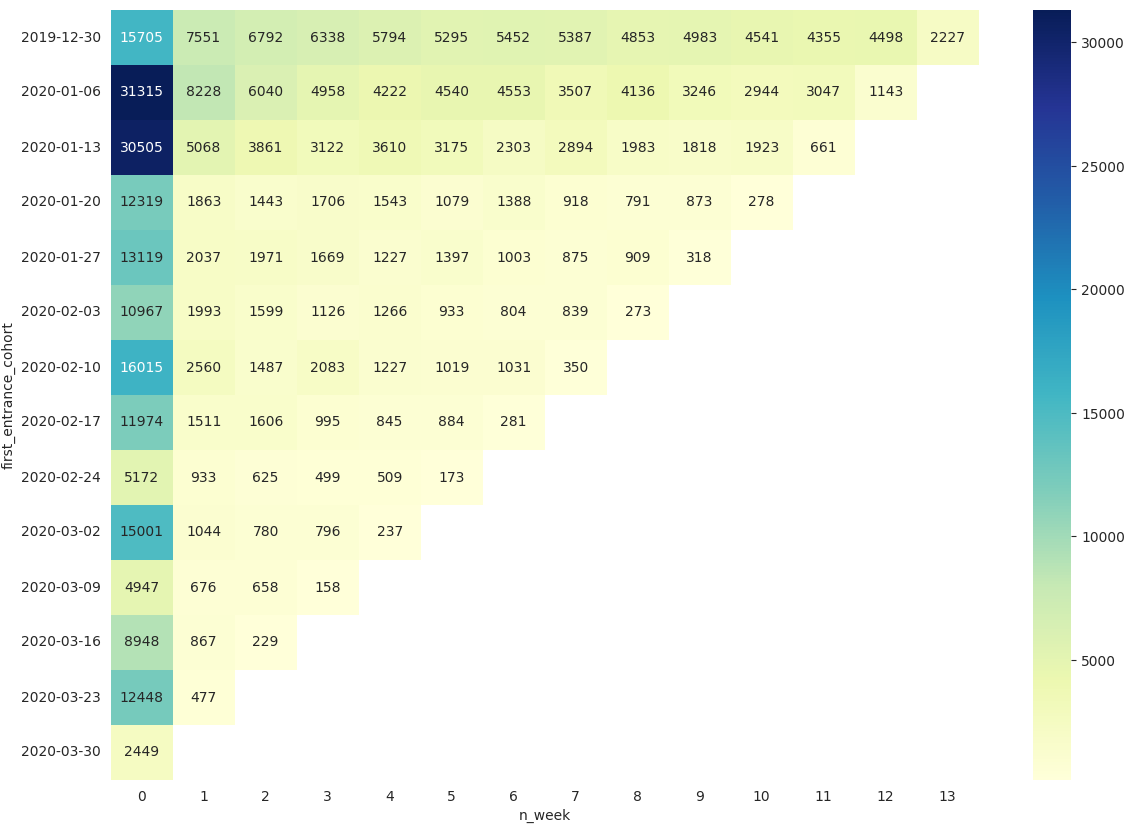

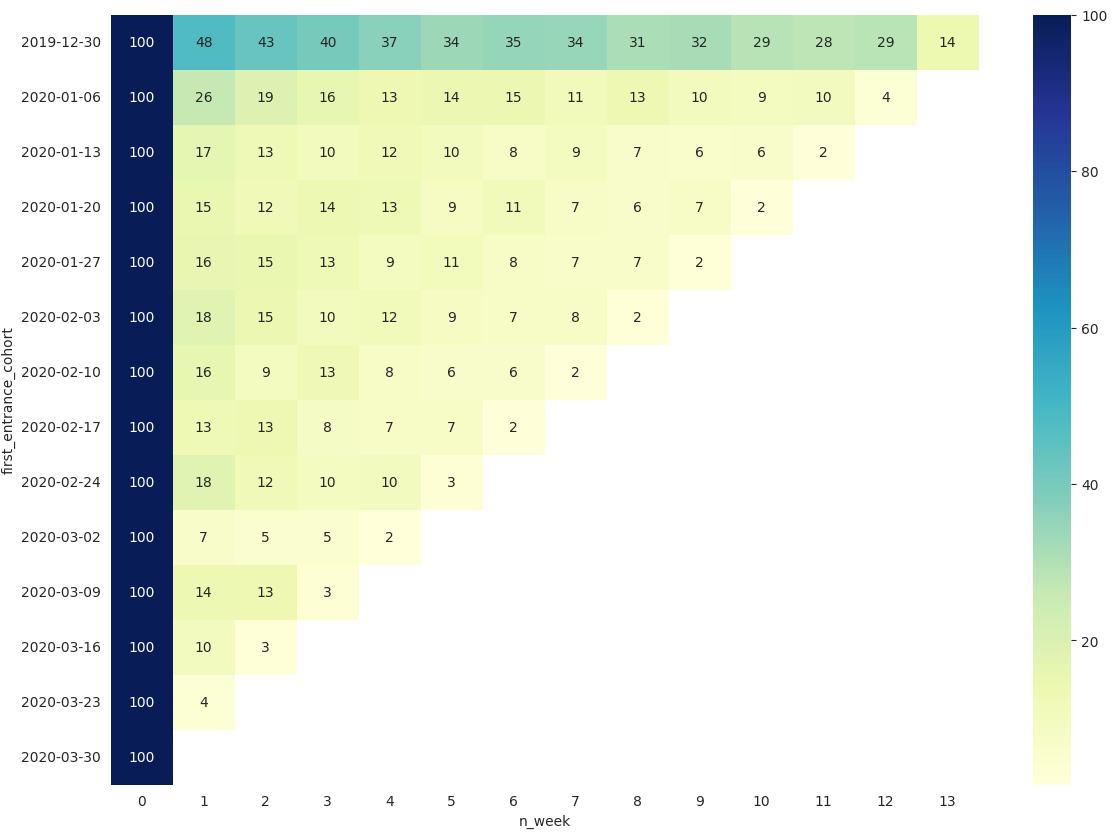

In [16]:


entrances = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id')
data['first_entrance'] = data['device_id'].map(entrances.set_index('device_id')['date'])
data['first_entrance'] = pd.to_datetime(data['first_entrance'], format = '%Y-%m-%d')
data['first_entrance_cohort'] = data['first_entrance'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data['n_week'] = data['date'] - data['first_entrance_cohort']
data['n_week'] = data['n_week'].apply(lambda x: x.days // 7 )
data['first_entrance_cohort'] = data['first_entrance_cohort'].apply(lambda x: str(x)[:10])
viz = data.pivot_table(
                        index='first_entrance_cohort', 
                        columns='n_week', 
                        values='device_id', 
                        aggfunc=pd.Series.nunique)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");
    
viz = viz.apply(lambda x: x*100/viz[0])
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");

Самая активная когорта — когорта, пришедшая на первой неделе . Активность этой когорты в несколько раз выше, чем у остальных. Эта же когорта приносит больше всего денег. Стоит стремиться к тому, чтобы все остальные когорты были похожи на неё.

C:\Users\New\AppData\Local\Temp\ipykernel_7480\283207563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_registration'] = pd.to_datetime(df['first_registration'], format = '%Y-%m-%d')
C:\Users\New\AppData\Local\Temp\ipykernel_7480\283207563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_registration_cohort'] = df['first_registration'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
C:\Users\New\AppData\Local\Temp\ipykernel_7480\283207563.py:4: SettingWithCopy

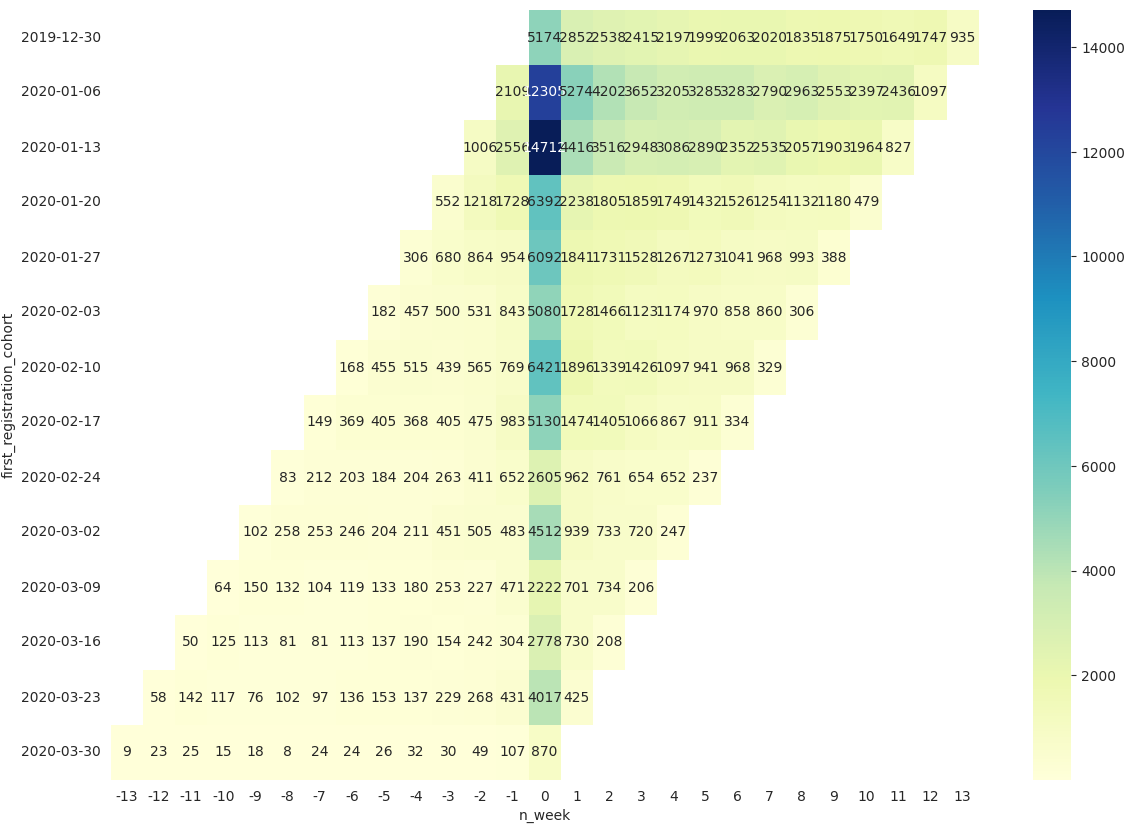

In [17]:
df = data[-data['first_registration'].isna()]
df['first_registration'] = pd.to_datetime(df['first_registration'], format = '%Y-%m-%d')
df['first_registration_cohort'] = df['first_registration'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['n_week'] = df['date'] - df['first_registration_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['first_registration_cohort'] = df['first_registration_cohort'].apply(lambda x: str(x)[:10])
viz = df.pivot_table(
                        index='first_registration_cohort', 
                        columns='n_week', 
                        values='device_id', 
                        aggfunc=pd.Series.nunique)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");

Форма heat map показывает нам, что многие пользователи несколько недель подряд заходят в приложение, прежде чем зарегистрироваться.

## 8.Составить таблицу когорт (в абс. и %) по неделе первой покупки, выбор самой активной когорты и анализ динамики активности.

Самая активная когорта

In [36]:
purchases = data[data['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id')
data['first_purchase'] = data['device_id'].map(purchases.set_index('device_id')['date'])
data['first_purchase'] = pd.to_datetime(data['first_purchase'], format = '%Y-%m-%d')
df = data[-data['first_purchase'].isna()]
df['first_purchase_cohort'] = df['first_purchase'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['n_week'] = df['date'] - df['first_purchase_cohort']
df['n_week'] = df['n_week'].apply(lambda x: x.days // 7 )
df['first_purchase_cohort'] = df['first_purchase_cohort'].apply(lambda x: str(x)[:10])

df = df[df['event'] == 'purchase']
cohort_data = df.groupby('first_purchase_cohort')['purchase_sum'].sum().reset_index(name = 'LTV').sort_values('LTV', ascending = False)
cohort_data

C:\Users\New\AppData\Local\Temp\ipykernel_7480\1413273928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_purchase_cohort'] = df['first_purchase'].apply(lambda x: x + datetime.timedelta(days=-x.weekday(), weeks=0))
C:\Users\New\AppData\Local\Temp\ipykernel_7480\1413273928.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
C:\Users\New\AppData\Local\Temp\ipykernel_7480\1413273928.py:7: SettingWithCopyWarning: 
A value is trying to be

,first_purchase_cohort,LTV
1,2020-01-06,19787838.0
2,2020-01-13,18852452.0
0,2019-12-30,12320177.5
3,2020-01-20,9018049.5
4,2020-01-27,7432634.0
6,2020-02-10,6766314.0
5,2020-02-03,6305237.0
7,2020-02-17,5398837.5
9,2020-03-02,3629773.0
8,2020-02-24,3067633.5


 Построение графика динамики активности когорт

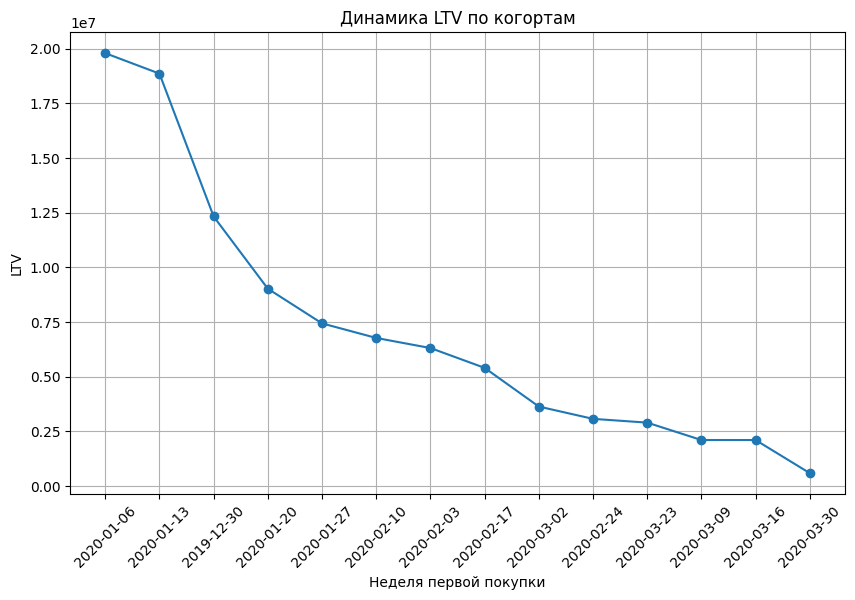

In [37]:

# Преобразование столбца 'LTV' в список
ltv_values = cohort_data['LTV'].tolist()

# Построение графика динамики показателя LTV по когортам
plt.figure(figsize=(10, 6))
plt.plot(cohort_data['first_purchase_cohort'], ltv_values, marker='o')
plt.xlabel('Неделя первой покупки')
plt.ylabel('LTV')
plt.title('Динамика LTV по когортам')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Вывод:  
Самая активная когорта по LTV  2020-01-06 . Данная когорта имеет наивысшее значение пожизненной ценности клиента (LTV) среди всех когорт . Анализ этой  когорты может помочь в понимании успешности стратегий привлечения и удержания клиентов, а также определении ключевых факторов, влияющих на LTV.

# 9.Расчитать средний/медианный чек по когортам (недели первой покупки) в каждую неделю с момента первой покупки, указание диапазонов.

Расчет медианного чека по когортам

C:\Users\New\AppData\Local\Temp\ipykernel_7480\1395957471.py:3: FutureWarning: The provided callable <function median at 0x000001A59F8BC790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  viz = df.pivot_table(


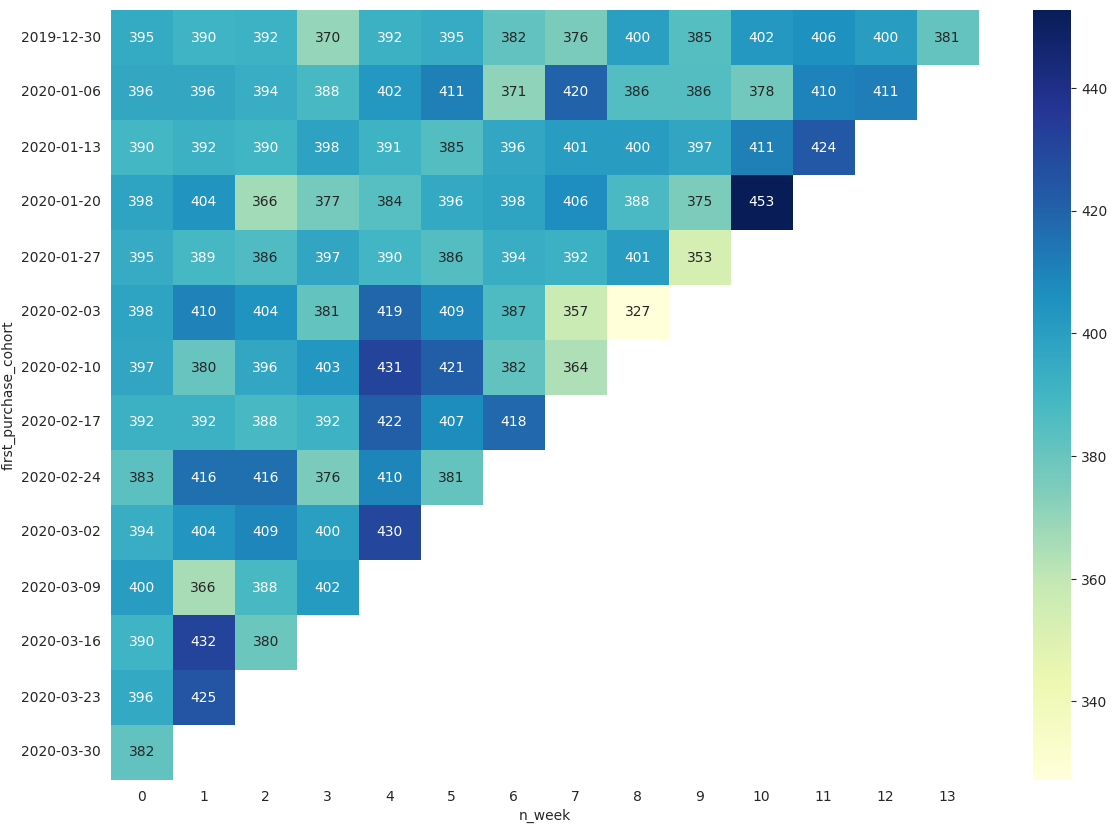

In [19]:


viz = df.pivot_table(
                        index='first_purchase_cohort', 
                        columns='n_week', 
                        values='purchase_sum', 
                        aggfunc=np.median)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");

Сравниваем  медианный чек на второй неделе с момента первой покупки для всех каналов привлечения. 

C:\Users\New\AppData\Local\Temp\ipykernel_7480\1414994926.py:1: FutureWarning: The provided callable <function median at 0x000001A59F8BC790> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  viz = df.pivot_table(


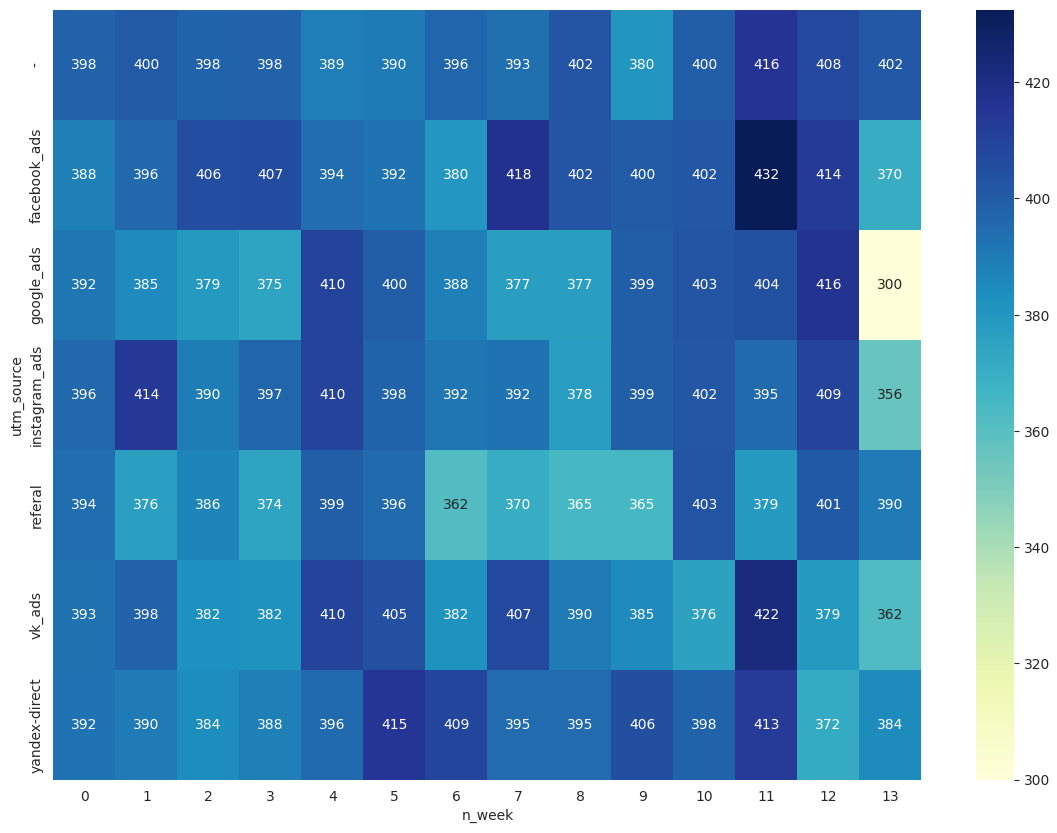

In [39]:
viz = df.pivot_table(
                        index='utm_source', 
                        columns='n_week', 
                        values='purchase_sum', 
                        aggfunc=np.median)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 10))
    ax = sns.heatmap(viz, annot=True, fmt=".0f", cmap="YlGnBu");